In [1]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import  KFold
# Ocultar todos os avisos
warnings.filterwarnings("ignore")




In [2]:

df = pd.read_csv('hcc-data.txt', na_values='?')
cols = ['genero', 'sintomas', 'alcool', 'antigeno_superficie_hepatite_b', 'antigeno_e_hepatite_b', 'antigeno_core_hepatite_B', 'antigeno_hepatite_c','cirrose',
'pais_endemico', 'fumante','diabetes','obesidade','hemocromatose', 'hipertensao_arterial', 'insuficiencia_renal_cronica',
'HIV','esteato_hepatite_nao_alcoolica', 'varizes_esofagicas', 'esplenomegalia', 'hipertensao_portal', 'trombose_veia_porta',
'metastases_hepatica', 'marca_radiologica', 'idade_diagnostico', 'gramas_de_alcool_dia', 'pacotes_cigarro_dia', 'performance_status',
'grau_encefalopatia','grau_ascite', 'INR', 'AFP', 'Hemoglobina', 'vol_corpuscular_medio', 'leucocito', 'plaquetas', 'albumina',
'biliburrina_total', 'alanina_transaminase', 'aspartato_aminotransferase', 'gama_glutamil_transferase', 'fosfatase_alcalina',
'proteina_totais', 'creatina', 'numero_de_nodulos', 'maior_diametro_nodulo', 'biliburrina_direta', 'ferro', 'saturacao_oxigenio', 'ferritina',
'sobreviveu_1_ano']
df.columns = cols
df['morreu_1_ano'] = np.where(df['sobreviveu_1_ano']==1,0,1)
alvo = 'morreu_1_ano'
df = df.drop(columns='sobreviveu_1_ano')

In [3]:
cols_pred=['sintomas', 'trombose_veia_porta', 'metastases_hepatica', 'idade_diagnostico', 'grau_ascite', 'INR', 'AFP', 'Hemoglobina', 'plaquetas', 'gama_glutamil_transferase', 'biliburrina_total', 'albumina', 'fosfatase_alcalina', 'maior_diametro_nodulo', 'ferro', 'ferritina', 'morreu_1_ano']
df = df[cols_pred]

In [4]:
from sklearn.model_selection import train_test_split
#dytpe = int para retornar os valores em inteiro(1 e 0) e nao booleanos(true e false)
df = pd.get_dummies(df, columns=['grau_ascite'], dtype=int)
print(df[["grau_ascite_1.0"  ,"grau_ascite_2.0"  ,"grau_ascite_3.0" ]].head())

   grau_ascite_1.0  grau_ascite_2.0  grau_ascite_3.0
0                1                0                0
1                1                0                0
2                0                1                0
3                1                0                0
4                1                0                0


In [5]:
X = df.drop(columns = alvo)
y = df[alvo]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


In [6]:
for col in X_train.columns:
    if len(X_train[col].dropna().unique()) > 2:
        # .T transpoe o dataframe 
        # DQ = distancia interquartil   
        df_desc = X_train[col].describe().T
        DQ = df_desc['75%'] - df_desc['25%']
        limite_inferior = df_desc['25%'] - 1.5*DQ
        limite_superior = df_desc['75%'] + 1.5*DQ
        # atribui valor nulo aos outliers
        X_train.loc[(X_train[col] > limite_superior), col] = limite_superior
        X_train.loc[(X_train[col] < limite_inferior), col] = limite_inferior
        X_test.loc[(X_test[col] > limite_superior), col] = limite_superior
        X_test.loc[(X_test[col] < limite_inferior), col] = limite_inferior

In [7]:
for col in X_train.columns:
    indexs = X_train[X_train[col].isnull()].index
    if len(indexs) > 0:
        if len(X_train[col].dropna().unique()) <= 2:
            X_train["%s_nulo" % col] = 0
            X_train.loc[indexs, col] = X_train[col].mode().values[0]
            X_train.loc[indexs, "%s_nulo" % col] =  1
        else:
            X_train["%s_nulo" % col] = 0
            X_train.loc[indexs, "%s_nulo" % col] = 1
            X_train.loc[indexs, col] = X_train[col].mean()
for col in X_test.columns:
    indexs = X_test[X_test[col].isnull()].index
    if len(indexs) > 0:
        if len(X_train[col].dropna().unique()) <= 2:
            X_test["%s_nulo" % col] = 0
            X_test.loc[indexs, col] = X_train[col].mode().values[0]
            X_test.loc[indexs, "%s_nulo" % col] = 1
        else:
            X_test["%s_nulo" % col] = 0
            X_test.loc[indexs, "%s_nulo" % col] = 1
            X_test.loc[indexs, col] = X_train[col].mean()

In [8]:
#adicionando as colunas dummies com tudo 0, pois a amostra de teste nao possue valores nulos no atributo
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
X_test = X_test[X_train.columns.tolist()]


In [9]:
# instância do modelo de Random Forest
rf_classifier = RandomForestClassifier()
#  hiperparâmetros e seus valores a serem testados
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3,5,10, 20, 30],
    'min_samples_split': [3, 5,7, 10],
    'min_samples_leaf': [3, 6, 9],
}

# GridSearchCV
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='roc_auc')

# treina o objeto GridSearchCV aos dados de treinamento
grid_search_rf.fit(X_train, y_train)

# Acessa os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados (Random Forest):")
print(grid_search_rf.best_params_)
# aloca os melhores hiperparametros no modelo
params_rf = grid_search_rf.best_params_

# instância do modelo de XGboost
xgb_classifier = XGBClassifier()
#  hiperparâmetros e seus valores a serem testados
param_grid = {
    'n_estimators': [100,200,300],
    'max_depth': [3,4,5, 6, 7,8],
    'learning_rate': [0.1,0.2, 0.3,0.4, 0.5],
}

GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, cv=10,n_jobs=2, scoring='roc_auc')

# treina o objeto GridSearchCV aos dados de treinamento
grid_search_xgb.fit(X_train, y_train)

# Acessa os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados (XGboost):")
print(grid_search_xgb.best_params_)
# aloca os melhores hiperparametros no modelo
params_xgb = grid_search_xgb.best_params_

# instância do modelo de redes neurais
nn_classifier = MLPClassifier()
# hiperparâmetros e seus valores a serem testados
param_grid = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.01, 0.1, 0.2],
    'alpha': [0.0001, 0.001, 0.01],
    'momentum': [0.5, 0.9, 0.99],
}

# GridSearchCV
grid_search_nn = GridSearchCV(estimator=nn_classifier, param_grid=param_grid, cv=3, scoring='roc_auc')

# treina o objeto GridSearchCV aos dados de treinamento
grid_search_nn.fit(X_train, y_train)

# Acessa os melhores hiperparâmetros encontrados
print("Melhores hiperparâmetros encontrados (Redes Neurais):")
print(grid_search_nn.best_params_)
# aloca os melhores hiperparametros no modelo
params_nn = grid_search_nn.best_params_


Melhores hiperparâmetros encontrados (Random Forest):
{'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 200}
Melhores hiperparâmetros encontrados (XGboost):
{'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 200}
Melhores hiperparâmetros encontrados (Redes Neurais):
{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.01, 'momentum': 0.99}


In [11]:
# listas que vao ser armazenadas os resultados das predicoes e os verdadeiros valores
# pp = resultados em probabilidade e p em classe
# rf = randomforest, xg = xgboost, nn = redes neurais
y_t = []
y_p_rf = []
y_pp_rf = []
y_p_xg = []
y_pp_xg = []
y_p_nn = []
y_pp_nn = []
x_train_all = []
y_train_all = []

for i in (range(40)):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    for train_index, test_index in kfold.split(X):
        # Dividir os dados em conjuntos de treinamento e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # pre processamento ja bisto 
        for col in X_train.columns:
            indexs = X_train[X_train[col].isnull()].index
            if len(X_train[col].dropna().unique()) > 2:
                df_desc = X_train[col].describe().T
                DQ = df_desc['75%'] - df_desc['25%']
                limite_inferior = df_desc['25%'] - 1.5*DQ
                limite_superior = df_desc['75%'] + 1.5*DQ
                X_train.loc[(X_train[col] > limite_superior), col] = limite_superior
                X_train.loc[(X_train[col] < limite_inferior), col] = limite_inferior
                X_test.loc[(X_test[col] > limite_superior), col] = limite_superior
                X_test.loc[(X_test[col] < limite_inferior), col] = limite_inferior
                if len(indexs) > 0:
                    X_train["%s_nulo" % col] = 0
                    X_train.loc[indexs, "%s_nulo" % col] = 1
                    X_train.loc[indexs, col] = X_train[col].mean()
            else:
                if len(indexs) > 0:
                    X_train["%s_nulo" % col] = 0
                    X_train.loc[indexs, col] = 0
                    X_train.loc[indexs, "%s_nulo" % col] = X_train[col].mode().values[0]
        for col in X_test.columns:
            indexs = X_test[X_test[col].isnull()].index
            if len(indexs) > 0:
                if len(X_train[col].dropna().unique()) > 2:
                    X_test["%s_nulo" % col] = 0
                    X_test.loc[indexs, col] = 0
                    X_test.loc[indexs, "%s_nulo" % col] = X_train[col].mode().values[0]
                else:
                    X_test["%s_nulo" % col] = 0
                    X_test.loc[indexs, "%s_nulo" % col] = 1
                    X_test.loc[indexs, col] = X_train[col].mean()
        for col1 in X_train.columns:
            if col1 not in X_test.columns:
                X_test[col1] = 0
        X_test = X_test[X_train.columns.tolist()]
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_data = sc.transform(X_train)
        X_train = pd.DataFrame(X_train_data, columns = X_train.columns)
        X_test_data = sc.transform(X_test)
        X_test = pd.DataFrame(X_test_data,columns=X_test.columns)
       
        # define os modelos com os hiperparametros do gridsearch
        random_forest = RandomForestClassifier(**params_rf)
        xg_boost = XGBClassifier(**params_xgb)
        neural_networks = MLPClassifier(**params_nn)
        
        #treina os modelos
        random_forest.fit(X_train, y_train)
        xg_boost.fit(X_train, y_train)
        neural_networks.fit(X_train, y_train)

        #armazena as predicoes em probabilidade e classe e o resultado real
        y_t.extend(y_test)
        y_p_rf.extend(random_forest.predict(X_test))
        y_pp_rf.extend(random_forest.predict_proba(X_test)[:,1])
        y_p_xg.extend(xg_boost.predict(X_test))
        y_pp_xg.extend(xg_boost.predict_proba(X_test)[:,1])
        y_p_nn.extend(neural_networks.predict(X_test))
        y_pp_nn.extend(neural_networks.predict_proba(X_test)[:,1])
        

Acurácia: 0.7054545454545454
Recall: 0.6702380952380952
Precisão: 0.6027837259100642
F1-Score: 0.6347237880496054


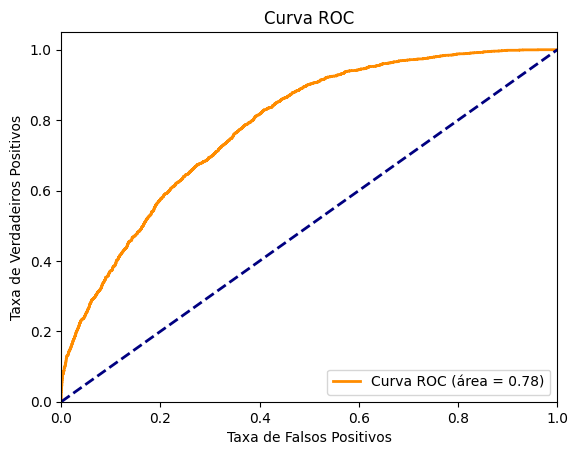

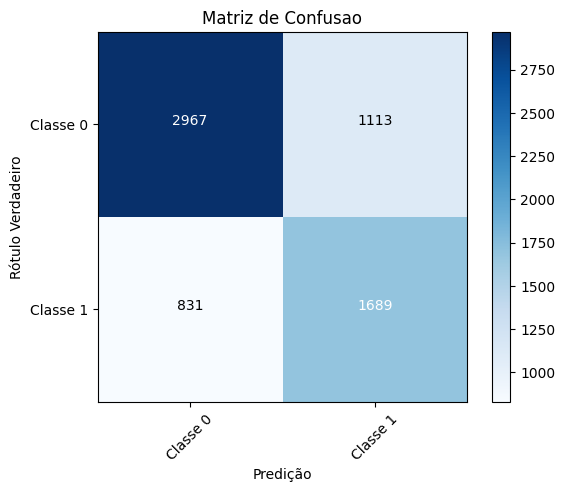

In [12]:
# Calcular as métricas 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = accuracy_score(y_t, y_p_xg)
recall = recall_score(y_t, y_p_xg)
precision = precision_score(y_t, y_p_xg)
f1 = f1_score(y_t, y_p_xg)

# Imprimir as métricas
print(f'Acurácia: {accuracy}')
print(f'Recall: {recall}')
print(f'Precisão: {precision}')
print(f'F1-Score: {f1}')


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Calcula a curva ROC e a área sob a curva ROC (ROC AUC)
fpr, tpr, thresholds = roc_curve(y_t, y_pp_xg)
roc_auc = roc_auc_score(y_t, y_pp_xg)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Exibir a plotagem da curva ROC
plt.show()

# Calcula a matriz de confusão
cm = confusion_matrix(y_t, y_p_xg)

# Definir rótulos das classes
class_labels = ['Classe 0', 'Classe 1']

# Plotar a matriz de confusão como um gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusao')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Adiciona os valores da matriz de confusão nas células da matriz
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição')

# Exibe a plotagem da matriz de confusão
plt.show()



Acurácia: 0.7356060606060606
Recall: 0.5456349206349206
Precisão: 0.6962025316455697
F1-Score: 0.6117908787541713


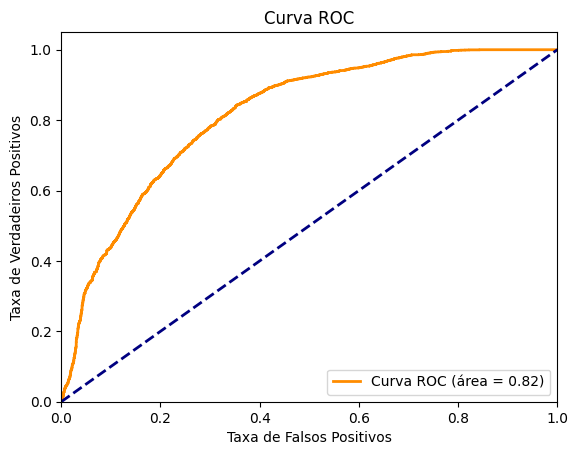

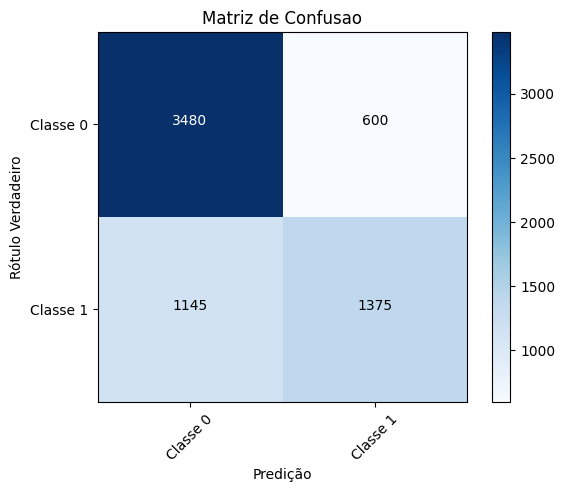

In [13]:
# Calcular as métricas 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = accuracy_score(y_t, y_p_rf)
recall = recall_score(y_t, y_p_rf)
precision = precision_score(y_t, y_p_rf)
f1 = f1_score(y_t, y_p_rf)

# Imprimir as métricas
print(f'Acurácia: {accuracy}')
print(f'Recall: {recall}')
print(f'Precisão: {precision}')
print(f'F1-Score: {f1}')


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Calcula a curva ROC e a área sob a curva ROC (ROC AUC)
fpr, tpr, thresholds = roc_curve(y_t, y_pp_rf)
roc_auc = roc_auc_score(y_t, y_pp_rf)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Exibir a plotagem da curva ROC
plt.show()

# Calcula a matriz de confusão
cm = confusion_matrix(y_t, y_p_rf)

# Definir rótulos das classes
class_labels = ['Classe 0', 'Classe 1']

# Plotar a matriz de confusão como um gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusao')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Adiciona os valores da matriz de confusão nas células da matriz
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição')

# Exibe a plotagem da matriz de confusão
plt.show()



In [14]:
y_p_rf = np.where(np.array(y_pp_rf) >=0.45,1,0)

Acurácia: 0.7395454545454545
Recall: 0.7071428571428572
Precisão: 0.6449511400651465
F1-Score: 0.6746166950596253


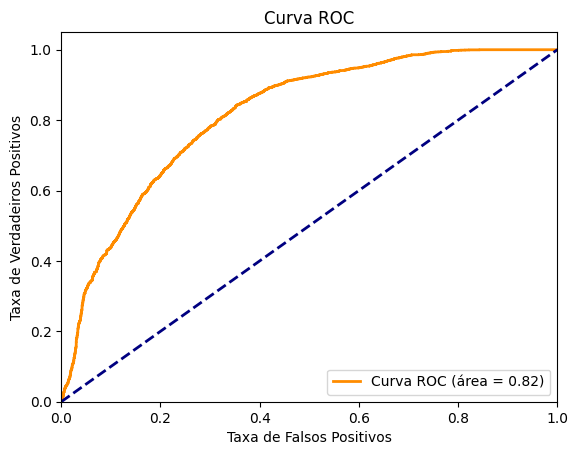

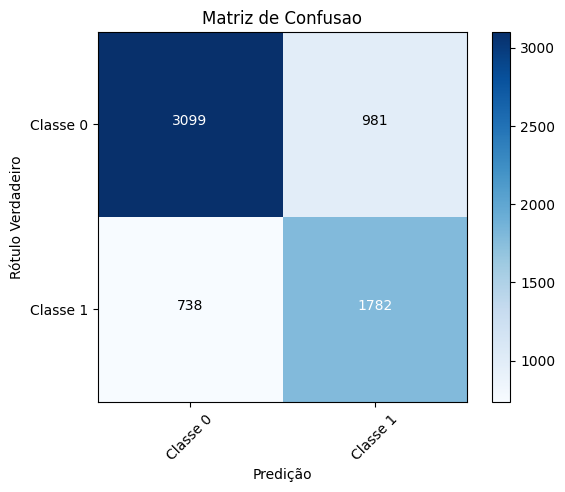

In [15]:
# Calcular as métricas 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = accuracy_score(y_t, y_p_rf)
recall = recall_score(y_t, y_p_rf)
precision = precision_score(y_t, y_p_rf)
f1 = f1_score(y_t, y_p_rf)

# Imprimir as métricas
print(f'Acurácia: {accuracy}')
print(f'Recall: {recall}')
print(f'Precisão: {precision}')
print(f'F1-Score: {f1}')


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Calcula a curva ROC e a área sob a curva ROC (ROC AUC)
fpr, tpr, thresholds = roc_curve(y_t, y_pp_rf)
roc_auc = roc_auc_score(y_t, y_pp_rf)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Exibir a plotagem da curva ROC
plt.show()

# Calcula a matriz de confusão
cm = confusion_matrix(y_t, y_p_rf)

# Definir rótulos das classes
class_labels = ['Classe 0', 'Classe 1']

# Plotar a matriz de confusão como um gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusao')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Adiciona os valores da matriz de confusão nas células da matriz
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição')

# Exibe a plotagem da matriz de confusão
plt.show()



Acurácia: 0.7087878787878787
Recall: 0.4726190476190476
Precisão: 0.6676008968609866
F1-Score: 0.5534386617100371


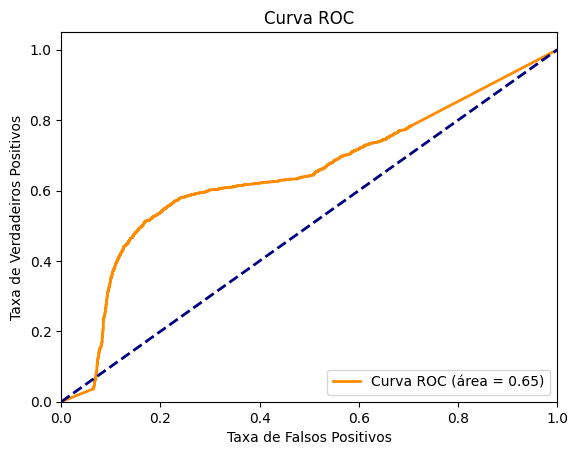

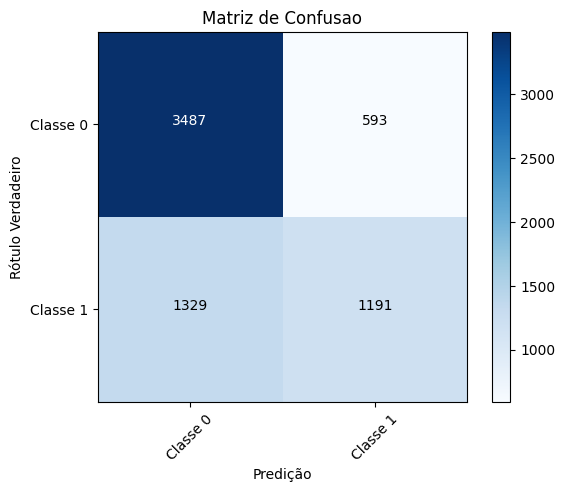

In [16]:
# Calcular as métricas 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy = accuracy_score(y_t, y_p_nn)
recall = recall_score(y_t, y_p_nn)
precision = precision_score(y_t, y_p_nn)
f1 = f1_score(y_t, y_p_nn)

# Imprimir as métricas
print(f'Acurácia: {accuracy}')
print(f'Recall: {recall}')
print(f'Precisão: {precision}')
print(f'F1-Score: {f1}')


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# Calcula a curva ROC e a área sob a curva ROC (ROC AUC)
fpr, tpr, thresholds = roc_curve(y_t, y_pp_nn)
roc_auc = roc_auc_score(y_t, y_pp_nn)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (área = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Exibir a plotagem da curva ROC
plt.show()

# Calcula a matriz de confusão
cm = confusion_matrix(y_t, y_p_nn)

# Definir rótulos das classes
class_labels = ['Classe 0', 'Classe 1']

# Plotar a matriz de confusão como um gráfico
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusao')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Adiciona os valores da matriz de confusão nas células da matriz
thresh = cm.max() / 2.0
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('Rótulo Verdadeiro')
plt.xlabel('Predição')

# Exibe a plotagem da matriz de confusão
plt.show()



In [17]:
# listas que vao ser armazenadas os resultados das predicoes e os verdadeiros valores
# pp = resultados em probabilidade e p em classe
# rf = randomforest, xg = xgboost, nn = redes neurais
y_t = []
y_p_rf = []
y_pp_rf = []
df_feat_imp = pd.DataFrame()

for i in (range(40)):
    kfold = KFold(n_splits=10, shuffle=True, random_state=i)
    for train_index, test_index in kfold.split(X):
        # Dividir os dados em conjuntos de treinamento e teste
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # pre processamento ja bisto 
        for col in X_train.columns:
            indexs = X_train[X_train[col].isnull()].index
            if len(X_train[col].dropna().unique()) > 2:
                df_desc = X_train[col].describe().T
                DQ = df_desc['75%'] - df_desc['25%']
                limite_inferior = df_desc['25%'] - 1.5*DQ
                limite_superior = df_desc['75%'] + 1.5*DQ
                X_train.loc[(X_train[col] > limite_superior), col] = limite_superior
                X_train.loc[(X_train[col] < limite_inferior), col] = limite_inferior
                X_test.loc[(X_test[col] > limite_superior), col] = limite_superior
                X_test.loc[(X_test[col] < limite_inferior), col] = limite_inferior
                if len(indexs) > 0:
                    X_train["%s_nulo" % col] = 0
                    X_train.loc[indexs, "%s_nulo" % col] = 1
                    X_train.loc[indexs, col] = X_train[col].mean()
            else:
                if len(indexs) > 0:
                    X_train["%s_nulo" % col] = 0
                    X_train.loc[indexs, col] = 0
                    X_train.loc[indexs, "%s_nulo" % col] = X_train[col].mode().values[0]
        for col in X_test.columns:
            indexs = X_test[X_test[col].isnull()].index
            if len(indexs) > 0:
                if len(X_train[col].dropna().unique()) > 2:
                    X_test["%s_nulo" % col] = 0
                    X_test.loc[indexs, col] = 0
                    X_test.loc[indexs, "%s_nulo" % col] = X_train[col].mode().values[0]
                else:
                    X_test["%s_nulo" % col] = 0
                    X_test.loc[indexs, "%s_nulo" % col] = 1
                    X_test.loc[indexs, col] = X_train[col].mean()
        for col1 in X_train.columns:
            if col1 not in X_test.columns:
                X_test[col1] = 0
        X_test = X_test[X_train.columns.tolist()]
        sc = StandardScaler()
        sc.fit(X_train)
        X_train_data = sc.transform(X_train)
        X_train = pd.DataFrame(X_train_data, columns = X_train.columns)
        X_test_data = sc.transform(X_test)
        X_test = pd.DataFrame(X_test_data,columns=X_test.columns)
       
        # define os modelos com os hiperparametros do gridsearch
        random_forest = RandomForestClassifier(**params_rf)
        
        #treina os modelos
        random_forest.fit(X_train, y_train)

        #armazena as predicoes em probabilidade e classe e o resultado real
        y_t.extend(y_test)
        y_p_rf.extend(random_forest.predict(X_test))
        y_pp_rf.extend(random_forest.predict_proba(X_test)[:,1])
        df_aux = pd.DataFrame({"val_rf":random_forest.feature_importances_, "var" : X_test.columns})
        df_feat_imp = pd.concat([df_feat_imp,df_aux])


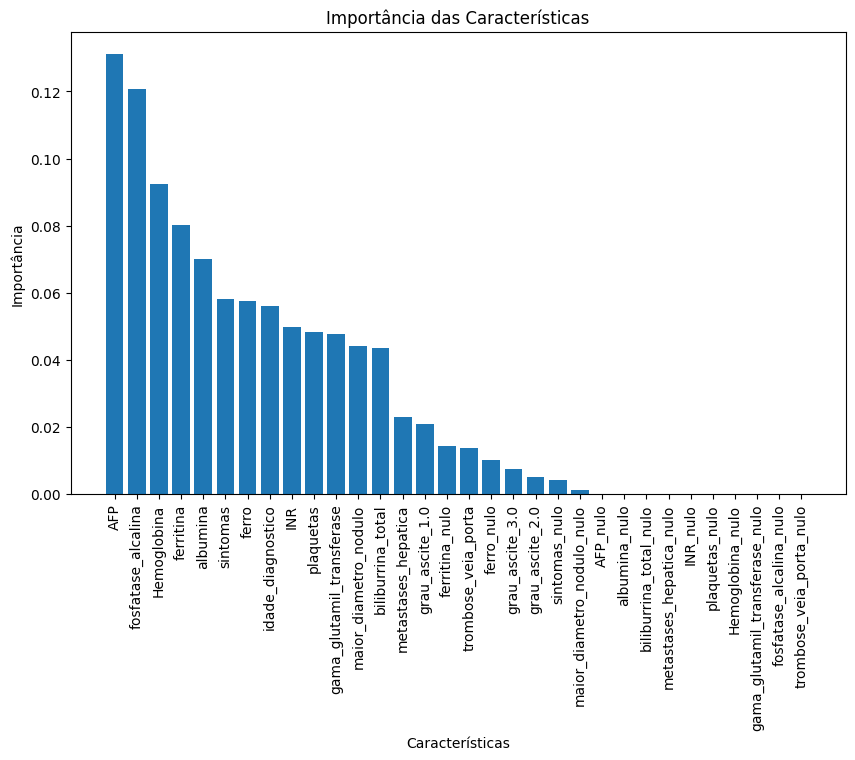

In [18]:
feature_importances_rf = df_feat_imp.groupby("var").mean().reset_index().sort_values("val_rf", ascending= False)

# Plotar a importância das características
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances_rf)), feature_importances_rf['val_rf'])
plt.xticks(range(len(feature_importances_rf)), feature_importances_rf['var'], rotation=90)
plt.xlabel('Características')
plt.ylabel('Importância')
plt.title('Importância das Características')
plt.show()

probabilidade de morte dentro de um ano: 0.37
média base do modelo: 0.38


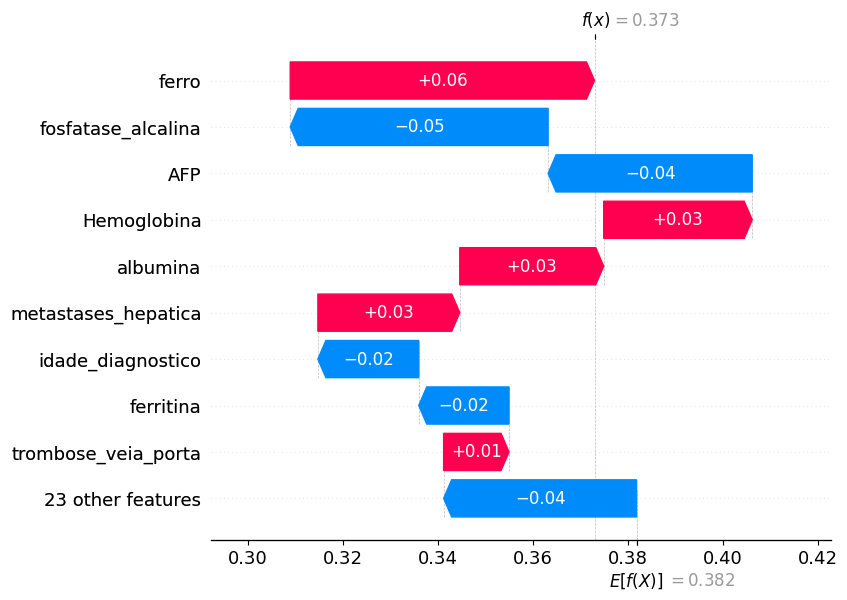

In [19]:
import shap

# Cria um novo modelo com os parametros escolhidos anteriormente
rcf = RandomForestClassifier(**params_rf)

#Realiza as tecnicas de pre processamento de dados
X = df.drop(columns = alvo)
y = df[alvo]

for col in X.columns:
    if len(X[col].dropna().unique()) > 2:
        # .T transpoe o dataframe 
        # DQ = distancia interquartil   
        df_desc = X[col].describe().T
        DQ = df_desc['75%'] - df_desc['25%']
        limite_inferior = df_desc['25%'] - 1.5*DQ
        limite_superior = df_desc['75%'] + 1.5*DQ
        # atribui valor nulo aos outliers
        X.loc[(X[col] > limite_superior), col] = limite_superior
        X.loc[(X[col] < limite_inferior), col] = limite_inferior
for col in X.columns:
    indexs = X[X[col].isnull()].index
    if len(indexs) > 0:
        if len(X[col].dropna().unique()) <= 2:
            X["%s_nulo" % col] = 0
            X.loc[indexs, col] = X[col].mode().values[0]
            X.loc[indexs, "%s_nulo" % col] =  1
        else:
            X["%s_nulo" % col] = 0
            X.loc[indexs, "%s_nulo" % col] = 1
            X.loc[indexs, col] = X[col].mean()

sc = StandardScaler()
sc.fit(X)
X_data = sc.transform(X)
X = pd.DataFrame(X_data, columns = X.columns)

#treina o modelo
rcf.fit(X,y)
#novo paciente com tudo = 1
novo_paciente = np.array([1 for i in range(len(X.columns))]).reshape(1, -1)
#os dados com o standard scaler
novo_paciente_sc = sc.transform(novo_paciente)
print(f"probabilidade de morte dentro de um ano: {round(rcf.predict_proba(novo_paciente_sc)[0][1],2)}")
# Objeto interpretador do modelo do shap
explainer = shap.TreeExplainer(rcf)
#valores das importancias dos atributos
shap_values = explainer.shap_values(novo_paciente_sc)
#valor base que é a média das predições da amostra de treino, pois o waterfall 
# vai partir deste valor base para até a predicao final
base_value = np.mean(y)
print(f"média base do modelo: {round(base_value,2)}")
shap.plots._waterfall.waterfall_legacy(expected_value=base_value, shap_values=shap_values[1][0], feature_names=X.columns, show=True)


In [20]:
X = df.drop(columns = alvo)
for col in X.columns:
    if len(X[col].dropna().unique()) > 2:
        # .T transpoe o dataframe 
        # DQ = distancia interquartil   
        df_desc = X[col].describe().T
        DQ = df_desc['75%'] - df_desc['25%']
        limite_inferior = df_desc['25%'] - 1.5*DQ
        limite_superior = df_desc['75%'] + 1.5*DQ
        # atribui valor nulo aos outliers
        X.loc[(X[col] > limite_superior), col] = limite_superior
        X.loc[(X[col] < limite_inferior), col] = limite_inferior
X[['ferro','Hemoglobina','fosfatase_alcalina']].describe().loc['mean']

ferro                  85.598837
Hemoglobina            12.889275
fosfatase_alcalina    198.292623
Name: mean, dtype: float64

In [21]:
import joblib
joblib.dump(rcf, "modelo_random_forest.joblib")
joblib.dump(sc, 'scaler.pkl')
df_means = X.describe().loc['mean'].reset_index()
df_means.columns = ['col','media']
df_means.to_csv("medias.csv", index = False)

In [22]:
base_value

0.38181818181818183

In [23]:
df_means

,col,media
0,sintomas,0.639456
1,trombose_veia_porta,0.222222
2,metastases_hepatica,0.223602
3,idade_diagnostico,64.878788
4,INR,1.376323
5,AFP,394.070255
6,Hemoglobina,12.889275
7,plaquetas,112988.743580
8,gama_glutamil_transferase,250.697840
9,biliburrina_total,2.121688
